# Homework 6
* classify mnist_test.csv dataset
* what is the highest validation set accuracy you get (95%...?)
  * consider normalizing the data
  * changing optimizer (sgd,rmsprop,adam)...
  * number of epochs
  * structure of the Neural Network (number of neurons)
  * you can convert the labels to one-hot
* remember to fix the randomizer (maybe with the same number as I have here for comparison)

## Solution

First, the basic modules and the dataset are loaded.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

mnist_test = pd.read_csv("mnist_test.csv")

Now a little sample of the images with their respective correct digits are shown:

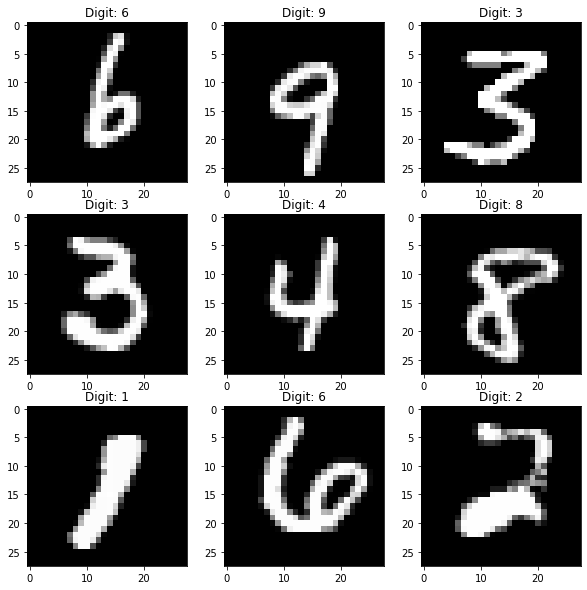

In [2]:
X_data = mnist_test.iloc[:,1:].to_numpy().reshape((10000, 28, 28))
y_data = mnist_test["label"].to_numpy()

plt.figure(figsize=(10,10))

random_imgs_idx = np.random.randint(0,10000,(25))

for i in range(3):
    for j in range(3):
        plt.subplot(3,3,i*3 + j + 1)
        plt.title("Digit: " + str(y_data[random_imgs_idx[i*5 + j]]))
        plt.imshow(X_data[random_imgs_idx[i*5 + j]], cmap="gray")

Next, a variety of options will be considered to check which one generates the most accurate predictions on the test data:
- Data normalized and not normalized
- 8 and 16 neurons in the middle layer
- One-hot encoding and numerical encoding
- Optimizer RMSProp and Adam
- 16 and 32 epochs

These are 5 hyperparameters to check, each one with two alternatives, and if all of the possible combinations are to be checked, this would mean that there will be $2^5=32$ models in total.

Now the model classes will be imported and a seed will be used:

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten
from tensorflow import one_hot
from sklearn.model_selection import train_test_split

tf.random.set_seed(1234)

All of the individual hyperparms will have their own function so they can be called when the hyperparams search is being performed:

In [4]:
X_data = mnist_test.iloc[:,1:].to_numpy()
y_data = mnist_test["label"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,test_size = 0.2)

def get_X_train_test(norm_type):
    if norm_type == "normalized":
        X_train_used = X_train/255.
        X_test_used = X_test/255.
    elif norm_type == "not_normalized":
        X_train_used = X_train
        X_test_used = X_test

    return X_train_used, X_test_used

def get_y_train_test_and_loss(encoding):
    if encoding == "one_hot":
        y_train_used = one_hot(y_train, depth=10)
        y_test_used = one_hot(y_test, depth=10)
        loss_used = "categorical_crossentropy"
    elif encoding == "numerical":
        y_train_used = y_train
        y_test_used = y_test
        loss_used = "sparse_categorical_crossentropy"
    
    return y_train_used, y_test_used, loss_used

def get_model(neurons_middle_layer):
    model = Sequential([
        InputLayer(input_shape=X_train[0].shape),
        Dense(units=neurons_middle_layer, activation='relu', name='layer_hidden'),
        Dense(units=10, activation='softmax', name='output_layer')
    ])
    return model

def compile_model(model, optimizer_used, loss_f):
    model.compile(
        optimizer=optimizer_used,
        loss=loss_f,
        metrics=['accuracy']
    )

And to create all of the possible alternatives, a `for` loop will be used, with all of the individual hyperparams having their own functions:

In [5]:
for normalized in ["normalized", "not_normalized"]:
    for neurons_middle_layer in [8, 16]:
        for encoding in ["one_hot", "numerical"]:
            for optimizer in ["rmsprop", "adam"]:
                for no_epochs in [16, 32]:
                    X_train_used, X_test_used = get_X_train_test(normalized)
                    model = get_model(neurons_middle_layer)
                    y_train_used, y_test_used, loss_used = get_y_train_test_and_loss(encoding)
                    compile_model(model, optimizer, loss_used)
                    model.fit(X_train_used, y_train_used, epochs=no_epochs, verbose=0)
                    loss, accuracy = model.evaluate(X_test_used, y_test_used)
                    print("For these params: ")
                    print("    Normalization: ", normalized)
                    print("    Neurons of middle layer: ", neurons_middle_layer)
                    print("    Encoding: ", encoding)
                    print("    Optimizer: ", optimizer)
                    print("    No. Epochs: ", no_epochs)
                    print("The accuracy is ", accuracy)

63/63 [==============================] - 0s 587us/step - loss: 0.3154 - accuracy: 0.9085
For these params: 
    Normalization:  normalized
    Neurons of middle layer:  8
    Encoding:  one_hot
    Optimizer:  rmsprop
    No. Epochs:  16
The accuracy is  0.9085000157356262
63/63 [==============================] - 0s 619us/step - loss: 0.3273 - accuracy: 0.9135
For these params: 
    Normalization:  normalized
    Neurons of middle layer:  8
    Encoding:  one_hot
    Optimizer:  rmsprop
    No. Epochs:  32
The accuracy is  0.9135000109672546
63/63 [==============================] - 0s 524us/step - loss: 0.3209 - accuracy: 0.9095
For these params: 
    Normalization:  normalized
    Neurons of middle layer:  8
    Encoding:  one_hot
    Optimizer:  adam
    No. Epochs:  16
The accuracy is  0.909500002861023
63/63 [==============================] - 0s 540us/step - loss: 0.3151 - accuracy: 0.9185
For these params: 
    Normalization:  normalized
    Neurons of middle layer:  8
    Encodin

As can be seen in the results, the largest accuracy achieved in the test set has been of 93.4%, which has been achieved by a model with these parameters:

- Normalization:  normalized
- Neurons of middle layer:  16
- Encoding:  one_hot
- Optimizer:  rmsprop
- No. Epochs:  32

Something interesting to notice is that the parameter that drops the accuracy the most by far is having the data not normalized. The other params give a good result with either of their two options.